In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os
import copy

import perturbseq as perturb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
rng=np.random.RandomState(1234)
import random
random.seed(1234)

In [3]:
PROTEIN='TP53'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

FIGS=DATA+'/2021-03-22_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2021-03-22_Figures/


In [4]:
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete3.csv',sep='\t',index_col=0)
anno=anno.loc[anno['Library_synthesis']=='in',:]

sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants_2021-03-23.csv',header=None)
sorted_variants_df.index=sorted_variants_df[0]
sorted_variants=list(sorted_variants_df[0])
print(sorted_variants)

print(anno.columns)

['P359P', 'T170T', 'D21D', 'A83V', 'P295P', 'P153P', 'E2E', 'P47P', 'R158R', 'T118T', 'Q5R', 'G360V', 'V31I', 'P36P', 'P58R', 'P301P', 'L344L', 'P47S', 'P222P', 'T312S', 'WT', 'E339K', 'Y107H', 'S366A', 'V216V', 'R337C', 'R337L', 'unassigned', 'R280K', 'C277F', 'R213Q', 'P152L', 'S241C', 'R273H', 'R273L', 'R273C', 'K132R', 'R158H', 'M246V', 'M237I', 'V272L', 'C242F', 'E271K', 'Y205C', 'G154V', 'Y234C', 'Y220C', 'G266E', 'Y236C', 'R280T', 'R158L', 'R248W', 'C238F', 'Y163C', 'G266V', 'A159V', 'E285K', 'G105C', 'G245C', 'H179R', 'K132N', 'S241F', 'R248L', 'V272M', 'H193R', 'G245S', 'P250L', 'P278L', 'C141Y', 'A159P', 'G244C', 'E286K', 'S127F', 'C238Y', 'V216M', 'V173L', 'V157F', 'C176Y', 'C176F', 'H214R', 'H193Y', 'R110L', 'C135Y', 'R249S', 'R282W', 'L194R', 'G266R', 'R249M', 'G245V', 'C275Y', 'H179Y', 'P151S', 'R175H', 'C135F', 'I195T', 'P278S', 'V173M', 'G245D', 'C275F', 'H193L']
Index(['Variant.1', 'Variant.1.1', 'Position', 'From', 'To', 'mutation_type',
       'Count_pancan', 'Count_

In [5]:
#read in Giacomelli data

f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2019-06-07/TP53/mutational_signatures/TP53_mutationalSignatures_Giacomelli.txt'
mutsig=pd.read_csv(f,sep='\t',skiprows=1)
mutsig.index=mutsig['Allele']
print(mutsig.head())
print(mutsig.columns)

#modify the names for the synonymous ones
import re
new_vars=[]
for i in range(mutsig.shape[0]):
    v=mutsig.index[i]
    new_var_here=v
    if 'B' in v:
        new_var_here=re.sub('B',v[0],v)
    new_vars.append(new_var_here)
mutsig.index=new_vars


       Allele AA_wt AA_variant  Position  A549_p53WT_Nutlin-3_Z-score  \
Allele                                                                  
R175H   R175H     R          H       175                     1.791388   
R248Q   R248Q     R          Q       248                     1.233480   
R273H   R273H     R          H       273                     1.145501   
R248W   R248W     R          W       248                     1.552718   
R273C   R273C     R          C       273                     1.261347   

        A549_p53NULL_Nutlin-3_Z-score  A549_p53NULL_Etoposide_Z-score  \
Allele                                                                  
R175H                        0.538396                       -0.744765   
R248Q                        0.217053                       -0.985385   
R273H                        1.077844                       -1.438387   
R248W                        0.613931                       -0.689231   
R273C                        0.314304             

In [6]:
#check which of our variants are in the Giacomelli dataset
overlapping=set(mutsig.index).intersection(set(anno.index))
print('variants in Giacomelli',len(overlapping))
print(overlapping)
missed=set(anno.index).difference(set(mutsig.index))
print('variants not in Giacomelli',len(missed))
print(missed)

variants in Giacomelli 98
{'C135Y', 'P222P', 'G266R', 'S366A', 'S241C', 'L194R', 'H193Y', 'E285K', 'T312S', 'R213Q', 'C238F', 'Y236C', 'V31I', 'R249M', 'C242F', 'P295P', 'R175H', 'R248W', 'H179R', 'Q5R', 'I195T', 'S241F', 'E271K', 'L344L', 'G245D', 'P278L', 'G266E', 'C176F', 'G245V', 'D21D', 'V173L', 'M246V', 'Y107H', 'V272M', 'R273L', 'R273C', 'R280K', 'P58R', 'C141Y', 'H193L', 'C135F', 'K132R', 'G245S', 'T118T', 'G245C', 'K132N', 'R158R', 'E286K', 'P250L', 'Y205C', 'H179Y', 'C238Y', 'R282W', 'C277F', 'G154V', 'Y163C', 'P153P', 'R158H', 'T170T', 'E339K', 'R249S', 'A159P', 'P278S', 'P151S', 'C275F', 'P301P', 'R337C', 'V272L', 'H214R', 'V216M', 'V173M', 'C275Y', 'V216V', 'V157F', 'R248L', 'Y220C', 'P47S', 'P359P', 'A83V', 'R337L', 'H193R', 'S127F', 'Y234C', 'G244C', 'G105C', 'R110L', 'C176Y', 'P152L', 'G266V', 'R158L', 'A159V', 'E2E', 'P36P', 'G360V', 'R280T', 'R273H', 'P47P', 'M237I'}
variants not in Giacomelli 1
{'WT'}


In [7]:
def fun_scatter(x,y,xname='x',yname='y',width=4,height=4,corrtype='spearman',
                xlim=None,ylim=None,
                **kwargs):
    from scipy.stats import spearmanr, pearsonr
    if corrtype=='spearman':
        corr=spearmanr(x,y,nan_policy='omit')
    if corrtype=='pearson':
        corr=pearsonr(x,y)
    c,p="%.2g" % corr[0],"%.3g" % corr[1]
    fig,plots=plt.subplots(1)
    fig.set_size_inches(width,height)
    plots.scatter(x,y,**kwargs)
    plots.set_xlabel(xname)
    plots.set_ylabel(yname)
    if xlim!=None:
        plots.set_xlim(xlim)
    if ylim!=None:
        plots.set_ylim(ylim)
    plots.set_title(corrtype+':'+str(c)+'\n'+'p:'+str(p))

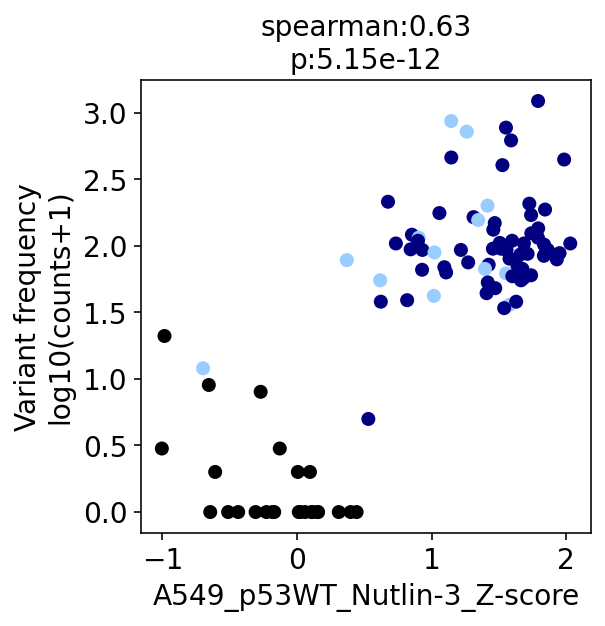

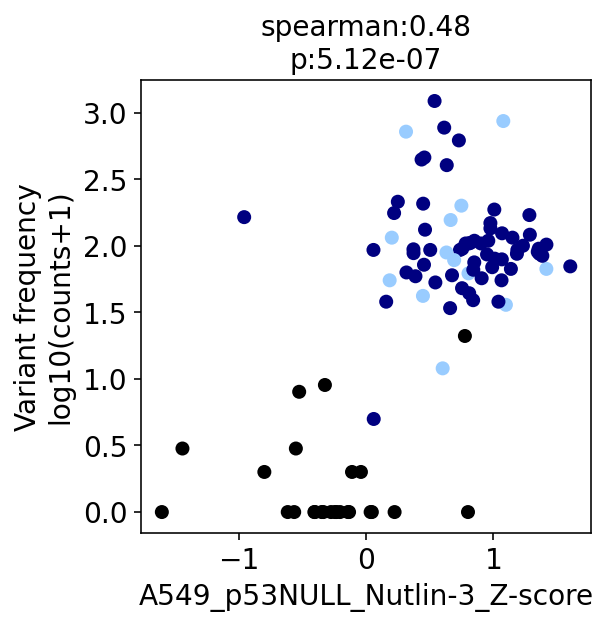

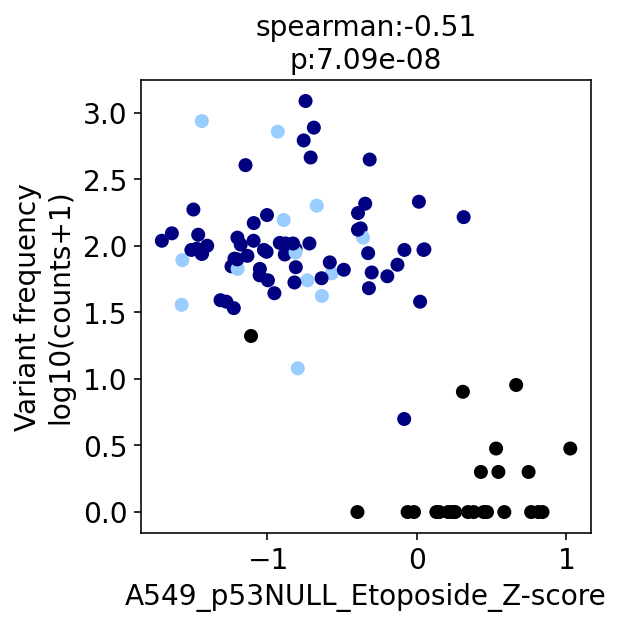

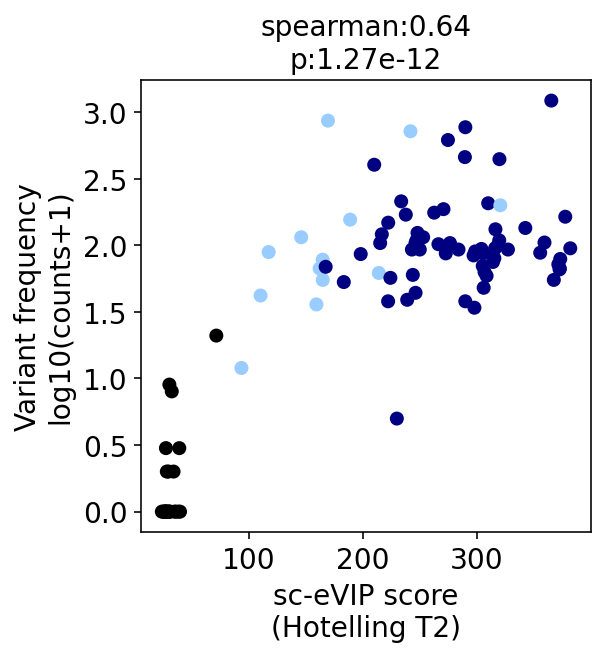

In [8]:
for f1 in ['A549_p53WT_Nutlin-3_Z-score',
           'A549_p53NULL_Nutlin-3_Z-score',
           'A549_p53NULL_Etoposide_Z-score',
           'HotellingT2']:
    mutcount='IARC_Mutation_Counts'
    fun_scatter(anno.loc[overlapping,f1],
                np.log10(mutsig.loc[overlapping,mutcount]+1),
               color=anno.loc[overlapping,'cluster_color'],
                xname=f1,yname='log counts',corrtype='spearman')
    plt.grid(False)
    plt.ylabel('Variant frequency\nlog10(counts+1)')
    if f1=='HotellingT2':
        plt.xlabel('sc-eVIP score\n(Hotelling T2)')
    
    plt.savefig(FIGS+'/'+PROTEIN+'.'+f1+'_vs_mutfreq.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.'+f1+'_vs_mutfreq.png',bbox_inches = "tight")
    plt.show()

In [9]:
#restrict to variants with features. excludes synonymous variants
f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2019-06-07/TP53/mutational_signatures/TP53_mutationalSignatures_Giacomelli.txt'
mutsig_init=pd.read_csv(f,sep='\t',skiprows=1)
mutsig_init=mutsig_init.iloc[:,:41]
mutsig_restricted=mutsig_init.dropna(axis='index')####### remove items without mutational signatures
mutsig_restricted.index=mutsig_restricted['Allele']

print(mutsig_restricted.head())
print(mutsig_restricted.shape)


       Allele AA_wt AA_variant  Position  A549_p53WT_Nutlin-3_Z-score  \
Allele                                                                  
R175H   R175H     R          H       175                     1.791388   
R248Q   R248Q     R          Q       248                     1.233480   
R273H   R273H     R          H       273                     1.145501   
R248W   R248W     R          W       248                     1.552718   
R273C   R273C     R          C       273                     1.261347   

        A549_p53NULL_Nutlin-3_Z-score  A549_p53NULL_Etoposide_Z-score  \
Allele                                                                  
R175H                        0.538396                       -0.744765   
R248Q                        0.217053                       -0.985385   
R273H                        1.077844                       -1.438387   
R248W                        0.613931                       -0.689231   
R273C                        0.314304             

data for model
==

In [10]:
#define data
data=pd.DataFrame(mutsig_restricted)
# need to add HotellingT2
data['HotellingT2']=anno.loc[data.index,'HotellingT2']

#check which of our variants are in the Giacomelli dataset
overlapping=set(mutsig_restricted.index).intersection(set(anno.index))
print('variants in Giacomelli',len(overlapping))
print(overlapping)
missed=set(anno.index).difference(set(mutsig_restricted.index))
print('variants not in Giacomelli',len(missed))
print(missed)

data['has_effsize']=False
data.loc[list(overlapping),'has_effsize']=True
data['constant']=1

print('Data',data.columns)

variants in Giacomelli 84
{'C135Y', 'E271K', 'G266R', 'G245D', 'H179Y', 'S366A', 'P278L', 'G266E', 'S241C', 'C176F', 'A83V', 'L194R', 'G245V', 'H193Y', 'C238Y', 'V173L', 'M246V', 'R282W', 'C277F', 'R158L', 'R337L', 'E285K', 'G154V', 'T312S', 'R213Q', 'Y107H', 'Y163C', 'H193R', 'C238F', 'R158H', 'Y236C', 'E339K', 'R249S', 'V31I', 'V272M', 'A159P', 'R249M', 'R273L', 'P278S', 'S127F', 'Y234C', 'G244C', 'G105C', 'C242F', 'P151S', 'C275F', 'R273C', 'R280K', 'R337C', 'P58R', 'R110L', 'C176Y', 'V272L', 'P152L', 'C141Y', 'R175H', 'H193L', 'C135F', 'R248W', 'H214R', 'G266V', 'K132R', 'G245S', 'V216M', 'A159V', 'H179R', 'G245C', 'V173M', 'K132N', 'C275Y', 'R280T', 'R273H', 'Q5R', 'V157F', 'I195T', 'M237I', 'S241F', 'E286K', 'R248L', 'G360V', 'P250L', 'Y220C', 'P47S', 'Y205C'}
variants not in Giacomelli 15
{'P153P', 'P301P', 'L344L', 'P222P', 'R158R', 'P295P', 'V216V', 'T170T', 'P47P', 'D21D', 'E2E', 'P36P', 'T118T', 'WT', 'P359P'}
Data Index(['Allele', 'AA_wt', 'AA_variant', 'Position',
       '

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [11]:
def get_positions_train_valid(data_pos,rng):
    
    positions=list(set(data_pos))
    train_positions=rng.choice(positions,size=int(len(positions)/2),replace=False)
    
    train_col=[]
    for j in range(len(data_pos)):
        curr_pos=data_pos[j]
        if curr_pos in train_positions:
            train_col.append(True)
        else:
            train_col.append(False)
    return(train_col)



In [12]:
#get positions not in the evip data
evip_positions=list(set(data.loc[data['has_effsize'],'Position']))
evip_positions.sort()
print(evip_positions)

[5, 31, 47, 58, 83, 105, 107, 110, 127, 132, 135, 141, 151, 152, 154, 157, 158, 159, 163, 173, 175, 176, 179, 193, 194, 195, 205, 213, 214, 216, 220, 234, 236, 237, 238, 241, 242, 244, 245, 246, 248, 249, 250, 266, 271, 272, 273, 275, 277, 278, 280, 282, 285, 286, 312, 337, 339, 360, 366]


In [13]:
train_positions=list(set(data['Position']).difference(set(evip_positions)))
print(train_positions)
print(data.shape)
print(data.loc[data['Position'].isin(train_positions),:].shape)
#split train positions into 2 halves
fold_train_positions=list(rng.choice(train_positions,int(len(train_positions)/2),replace=False))
print(fold_train_positions)

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 155, 156, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 215, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 239, 240, 243, 247, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 2

In [14]:
for i in range(1):
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng_fold=np.random.RandomState(i)
    #fold_train_positions=list(rng_fold.choice(train_positions,int(len(train_positions)/2),replace=False))
    #data[foldname]=data['Position'].isin(fold_train_positions)
    data[foldname]=data['Position'].isin(train_positions)
    print(data[foldname].value_counts())
    
    data[foldname+'not']=(data[foldname]==False)
    data.to_csv(DATA+'/mutfreq/TP53.training_data.'+foldname+'.csv')
    print(DATA+'/mutfreq/TP53.training_data.'+foldname+'.csv')

True     2046
False     368
Name: fold0, dtype: int64
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/TP53.training_data.fold0.csv


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


[<matplotlib.lines.Line2D object at 0x2b1cded39908>, <matplotlib.lines.Line2D object at 0x2b1cdee08630>] [2.0, 40.0]


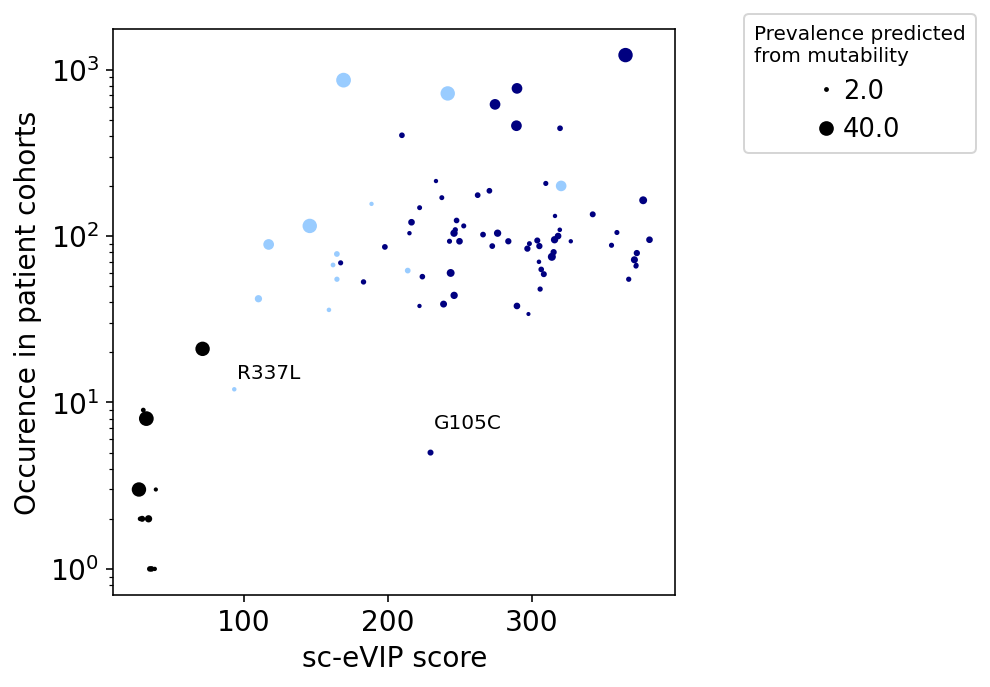

In [82]:
#plot for fig 5
fold=0
foldname='fold'+str(fold)
preds=pd.read_csv(DATA+'/mutfreq/TP53.training_data.'+foldname+'.pred.csv',
                     sep=' ')
preds.index=list(preds['Allele'])

present_variants=list(set(sorted_variants).intersection(set(preds.index)))

anno.loc['unassigned','cluster_color']='slateblue'
fig,plots=plt.subplots()
fig.set_size_inches(5,5)
scatter_output=plots.scatter(list(anno.loc[present_variants,'HotellingT2']),
           list(mutsig.loc[present_variants,'IARC_Mutation_Counts']+1),
           s=preds.loc[present_variants,'predicted.mutonly.response'],
              c=anno.loc[present_variants,'cluster_color'],
              vmax=20,cmap='viridis',
                            )

plots.set_xlabel('sc-eVIP score')
plots.set_ylabel('Occurence in patient cohorts')
plots.grid(False)
for i, txt in enumerate(sorted_variants):
    if txt not in ['R337L','G105C']:
        continue
    plots.annotate(txt, (anno.loc[sorted_variants,'HotellingT2'][i]+2, 
                             mutsig.loc[sorted_variants,'IARC_Mutation_Counts'][i]+1+2),
                       fontsize=10,color='black')
plots.set_yscale('log')



handles, labels = scatter_output.legend_elements(prop="sizes", num=40)
labels2=[]
import re
for i in range(len(labels)):
    i_num=float(re.sub('\$\\\\mathdefault{','',re.sub('}\$','',labels[i])))
    labels2.append(i_num)
min_size=labels2[0]
max_size=labels2[len(labels2)-1]
min_handle=handles[0]
labels_ends=[min_size,max_size]
handles_ends=[handles[0],handles[len(handles)-1]]
print(handles_ends, labels_ends)

legend2 = plots.legend(handles_ends, labels_ends, #loc="upper left", 
                          title="Prevalence predicted\nfrom mutability",
                       bbox_to_anchor=(1.1, 1.05))


plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.png',bbox_inches = "tight")

In [83]:
preds.loc[['R337L','G105C'],:]

,Allele,predicted.mutonly.response,predicted.mutonly.terms
R337L,R337L,1.498133,0.40422
G105C,G105C,4.014649,1.38995


In [84]:
preds['predicted.mutonly.response'].max()

40.4957513672314

In [85]:
#make the data for all the individual models

for i in range(10):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    data.to_csv(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.csv')
    print(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.csv')

=============== iteration 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/TP53.model_comparison.fold0.csv
=============== iteration 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/TP53.model_comparison.fold1.csv
=============== iteration 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/TP53.model_comparison.fold2.csv
=============== iteration 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/TP53.model_comparison.fold3.csv
=============== iteration 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/TP53.model_comparison.fold4.csv
=============== iteration 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/mutfreq/

=============== iteration 0
=============== iteration 1
=============== iteration 2
=============== iteration 3
=============== iteration 4
=============== iteration 5
=============== iteration 6
=============== iteration 7
=============== iteration 8
=============== iteration 9


Text(0.1, 0.5, 'predicted\nlog10(1+counts)')

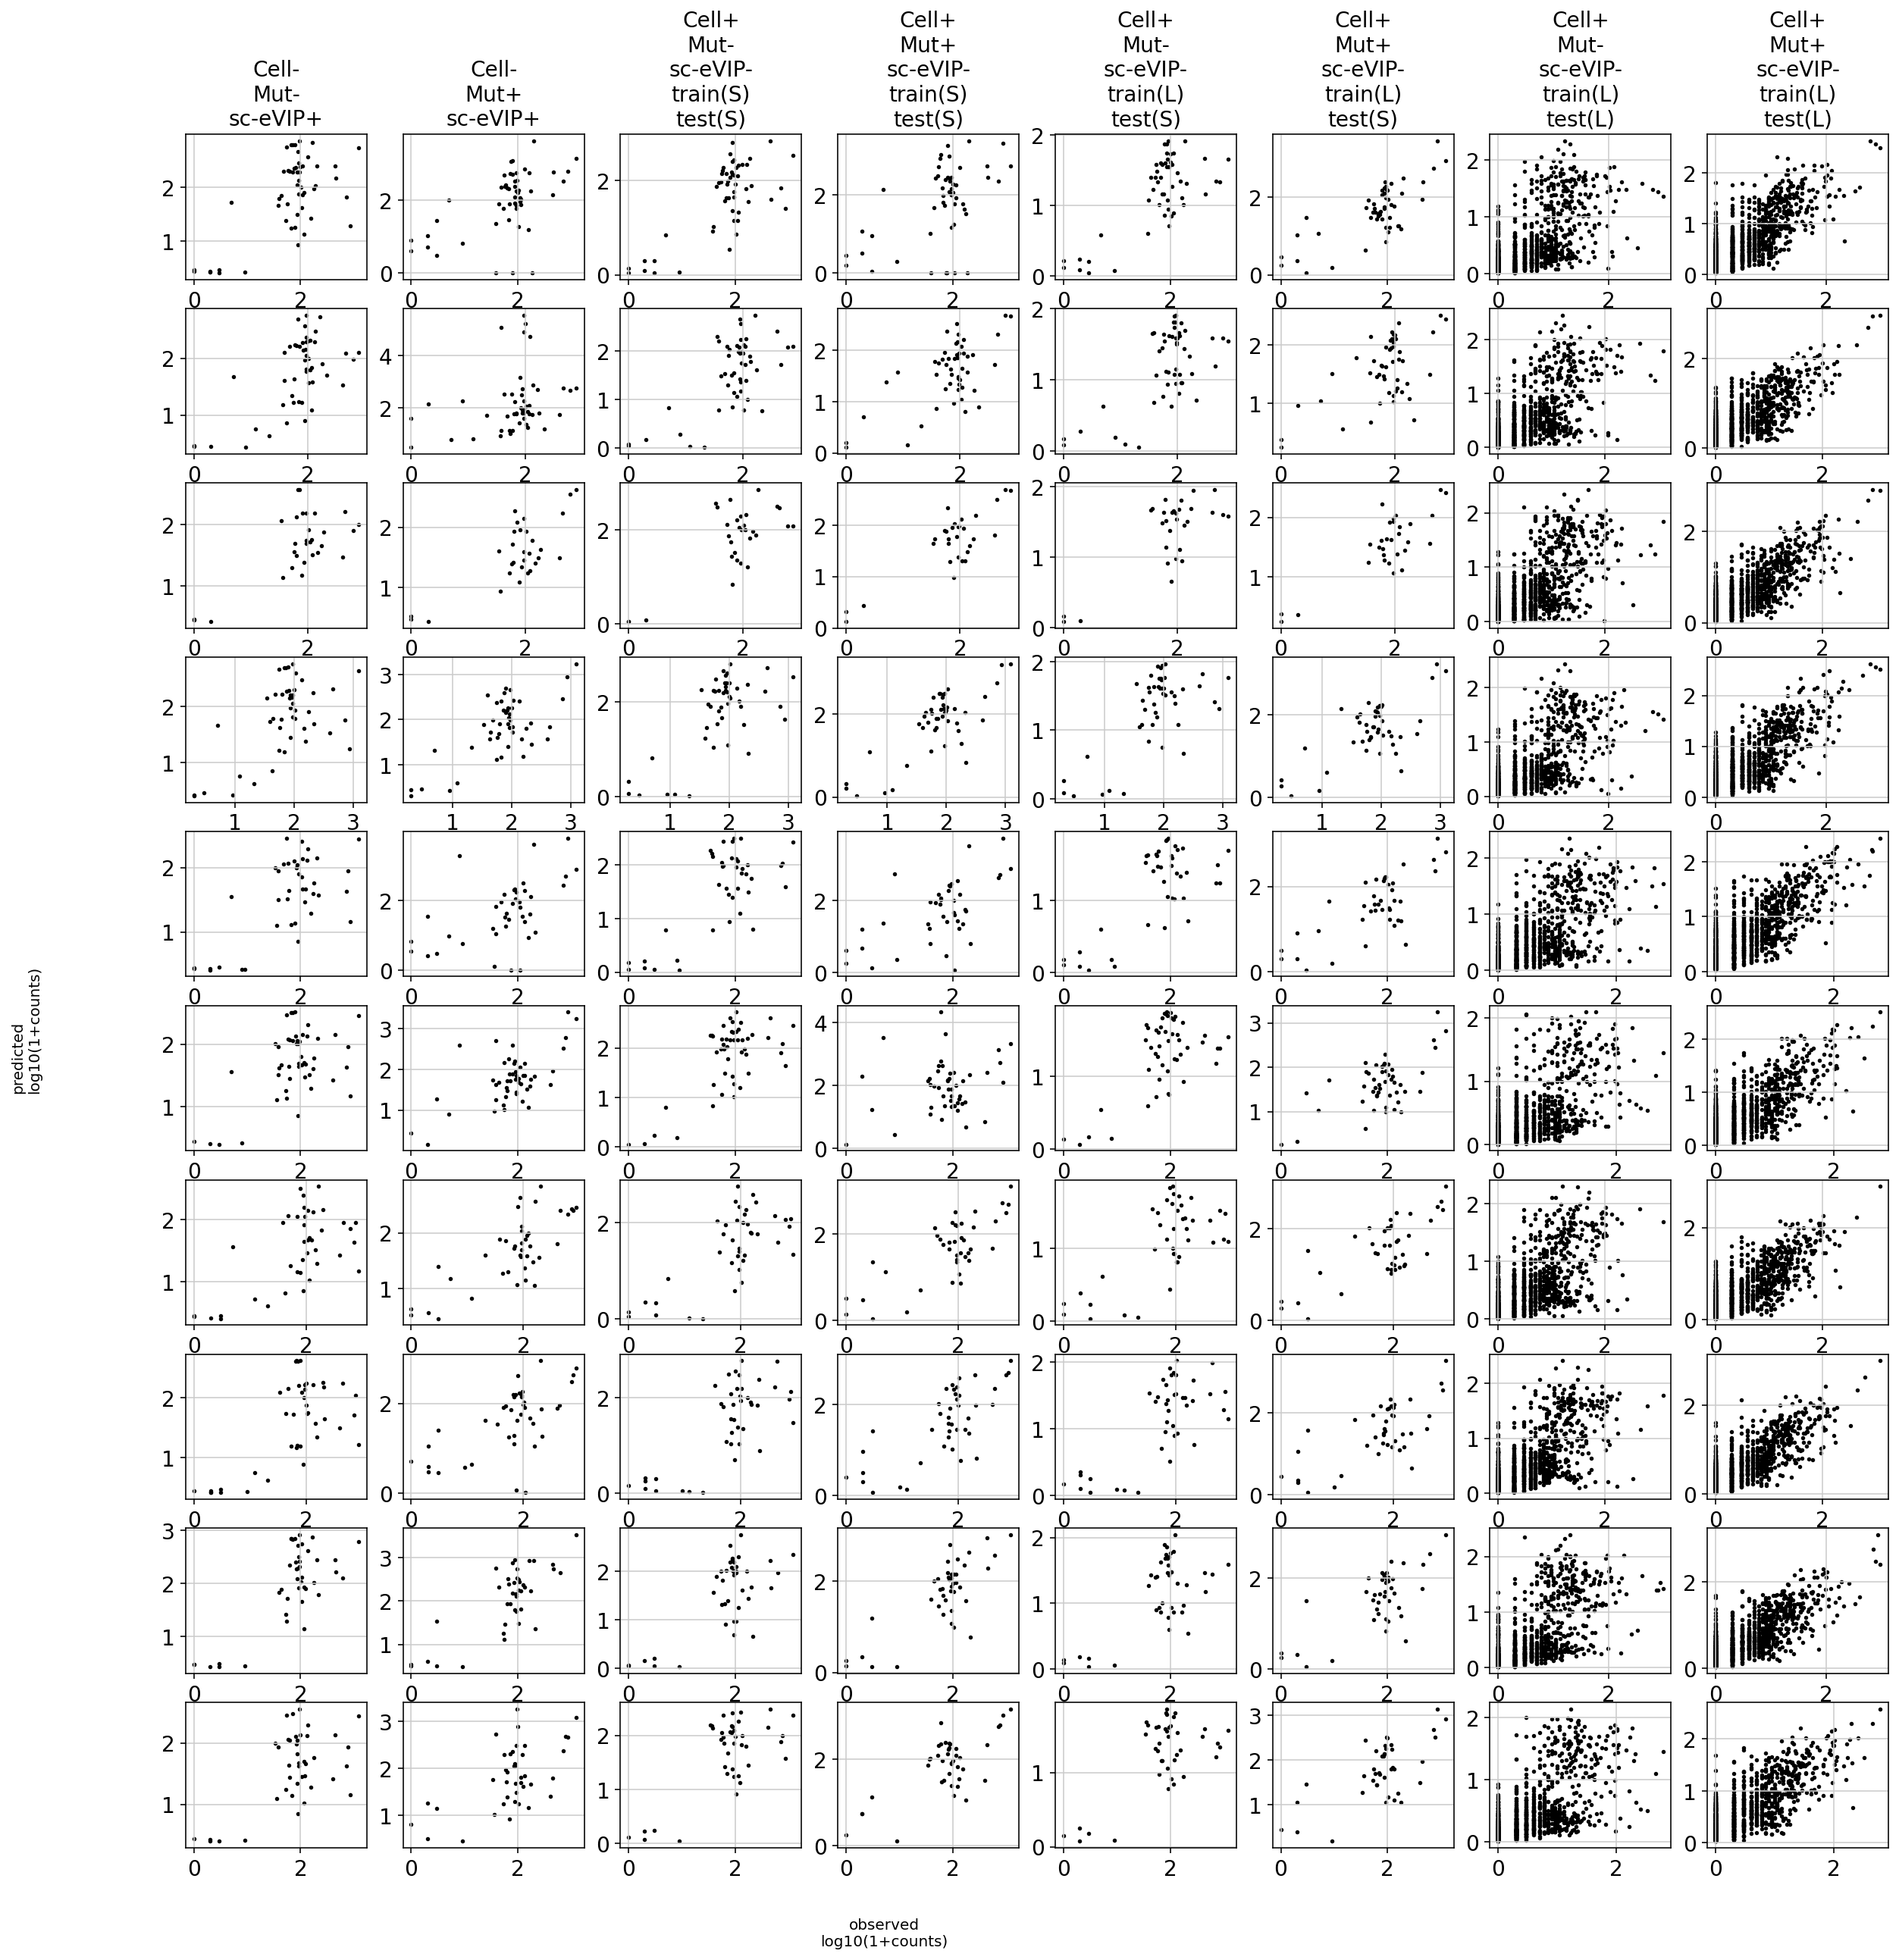

In [14]:
#read in all the predictions and compute performance

from scipy.stats import spearmanr,pearsonr

performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
ground_truth='IARC_Mutation_Counts'

models=['Cell- Mut- sc-eVIP+',
        'Cell- Mut+ sc-eVIP+',
        
        'Cell+ Mut- sc-eVIP- train(S) test(S)',
        'Cell+ Mut+ sc-eVIP- train(S) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(S)',
        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(L)',
        'Cell+ Mut+ sc-eVIP- train(L) test(L)',
       ]

fig,plots=plt.subplots(10,len(models))
fig.set_size_inches(20,20)


for i in range(10):
    print('=============== iteration',i)
    foldname='fold'+str(i)
    
    preds=pd.read_csv(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.pred.csv',sep='\t')
    preds.index=preds['Allele']
    
    m_idx=0
    for modelname in models:
        
        if modelname in ['Cell+ Mut+ sc-eVIP- train(S) test(S)',
                        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut+ sc-eVIP- train L test L',
                        
                        'Cell+ Mut- sc-eVIP- train(S) test(S)',
                        'Cell+ Mut- sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut- sc-eVIP- train L test L',
                        
                        'Cell- Mut- sc-eVIP+',
                        'Cell- Mut+ sc-eVIP+']:
            entries=preds.loc[preds['valid'+foldname],:].index
        else:
            entries=preds.loc[preds[foldname],:].index
            
        a=np.log10(1+preds.loc[entries,ground_truth])
        b=np.log10(1+preds.loc[entries,modelname])
        
        plots[i,m_idx].scatter(a,b,color='black',s=3)
        if i==0:
            plots[i,m_idx].set_title(re.sub(' ','\n',modelname))
            
        
        #measures
        s=spearmanr(a,b,nan_policy='omit')[0]
        p=pearsonr(a,b)[0]
        from sklearn.metrics import r2_score
        r2=r2_score(a,b)
        
        performances=pd.concat([performances,
                              pd.DataFrame({'condition':re.sub(' ','\n',modelname),
                                           'pearson':p,
                                           'spearman':s,
                                           'r2':r2,
                                           'fold':foldname},index=[modelname+foldname])])
        m_idx+=1
    #also do a shuffled
    entries=preds.loc[preds['valid'+foldname],:].index
            
    a=np.log10(1+preds.loc[entries,ground_truth])
    b=np.log10(1+preds.loc[entries,ground_truth])
    shuffle_rng=np.random.RandomState(i)
    b=shuffle_rng.choice(b,size=len(b),replace=False)

    #measures
    s=spearmanr(a,b,nan_policy='omit')[0]
    p=pearsonr(a,b)[0]
    from sklearn.metrics import r2_score
    r2=r2_score(a,b)

    performances=pd.concat([performances,
                          pd.DataFrame({'condition':'shuffled',
                                       'pearson':p,
                                       'spearman':s,
                                       'r2':r2,
                                       'fold':foldname},index=['shuffled'+foldname])])
fig.text(0.5, 0.08, 'observed\nlog10(1+counts)', ha='center')
fig.text(0.1, 0.5, 'predicted\nlog10(1+counts)', va='center', rotation='vertical')

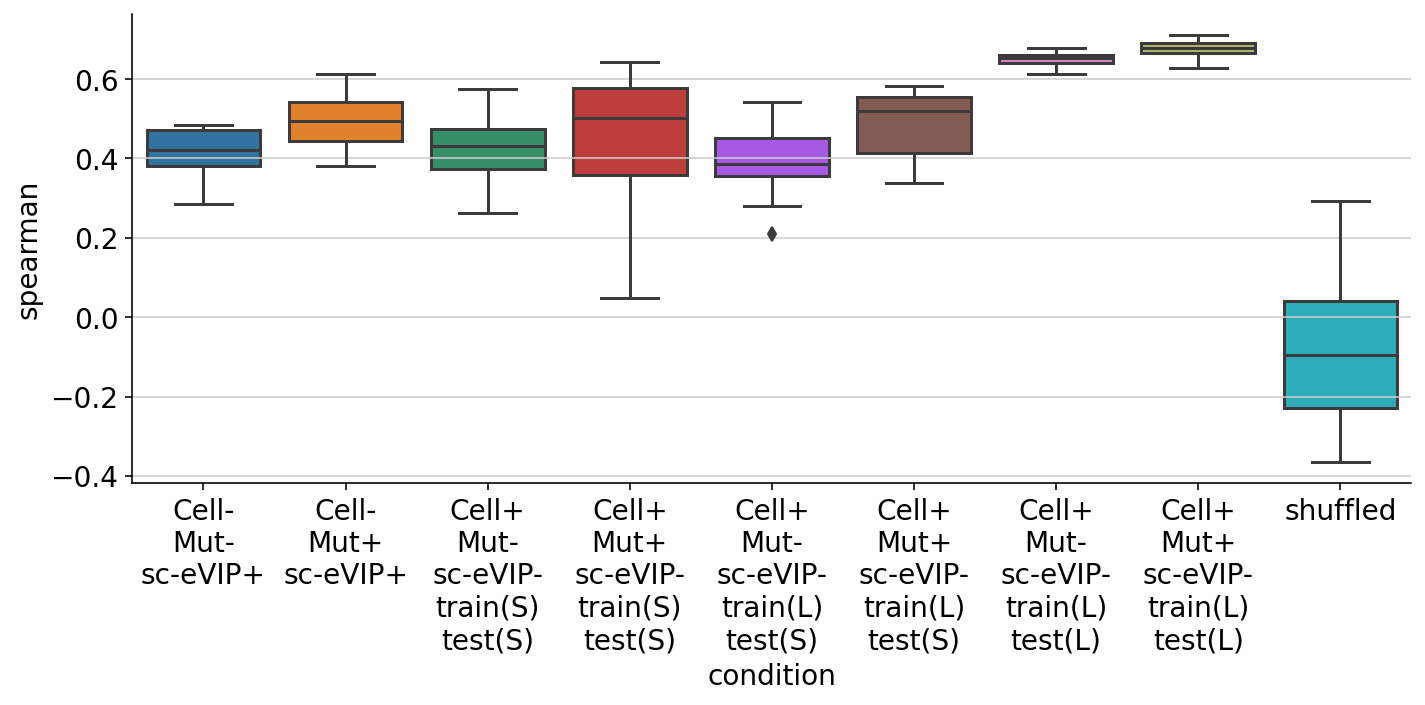

In [15]:
color_dict={}
for m in models:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

sns.catplot(data=performances,x='condition',y='spearman',kind='box',aspect=2,
           #palette=color_dict
           )


In [16]:
item='r2'
performances.groupby('condition', as_index=False)[item].median()

,condition,r2
0,Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L),0.474405
1,Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S),0.327229
2,Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S),0.358402
3,Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(L),0.396691
4,Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S),-0.443458
5,Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S),0.219865
6,Cell-\nMut+\nsc-eVIP+,0.203333
7,Cell-\nMut-\nsc-eVIP+,0.213758
8,shuffled,-1.229418


myorder ['Cell-\nMut-\nsc-eVIP+', 'Cell-\nMut+\nsc-eVIP+', 'Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)', 'shuffled']
[('Cell-\nMut-\nsc-eVIP+', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell-\nMut+\nsc-eVIP+'), ('shuffled', 'Cell-\nMut+\nsc-eVIP+')]
r2                                           Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S)  \
Cell-\nMut-\nsc-eVIP+                                     

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Cell-
Mut-
sc-eVIP+ v.s. Cell-
Mut+
sc-eVIP+: Custom statistical test, P_val:3.140e-02
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut-
sc-eVIP-
train(S)
test(S): Custom statistical test, P_val:1.786e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut+
sc-eVIP-
train(S)
test(S): Custom statistical test, P_val:6.400e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut-
sc-eVIP-
train(L)
test(S): Custom statistical test, P_val:2.181e-02
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut+
sc-eVIP-
train(L)
test(S): Custom statistical test, P_val:9.591e-01
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut-
sc-eVIP-
train(L)
test(L): Custom statistical test, P_val:1.467e-05
Cell-
Mut+
sc-eVIP+ v.s. Cell+
Mut+
sc-eVIP-
train(L)
test(L): Custom statistical test, P_val:3.393e-06
Cell-
Mut+
sc-eVIP+ v.s. shuffled: Custom statistical test, P_val:3.393e-06
p-value annotation legend:
ns: 5.00e-02 < p <= 1.

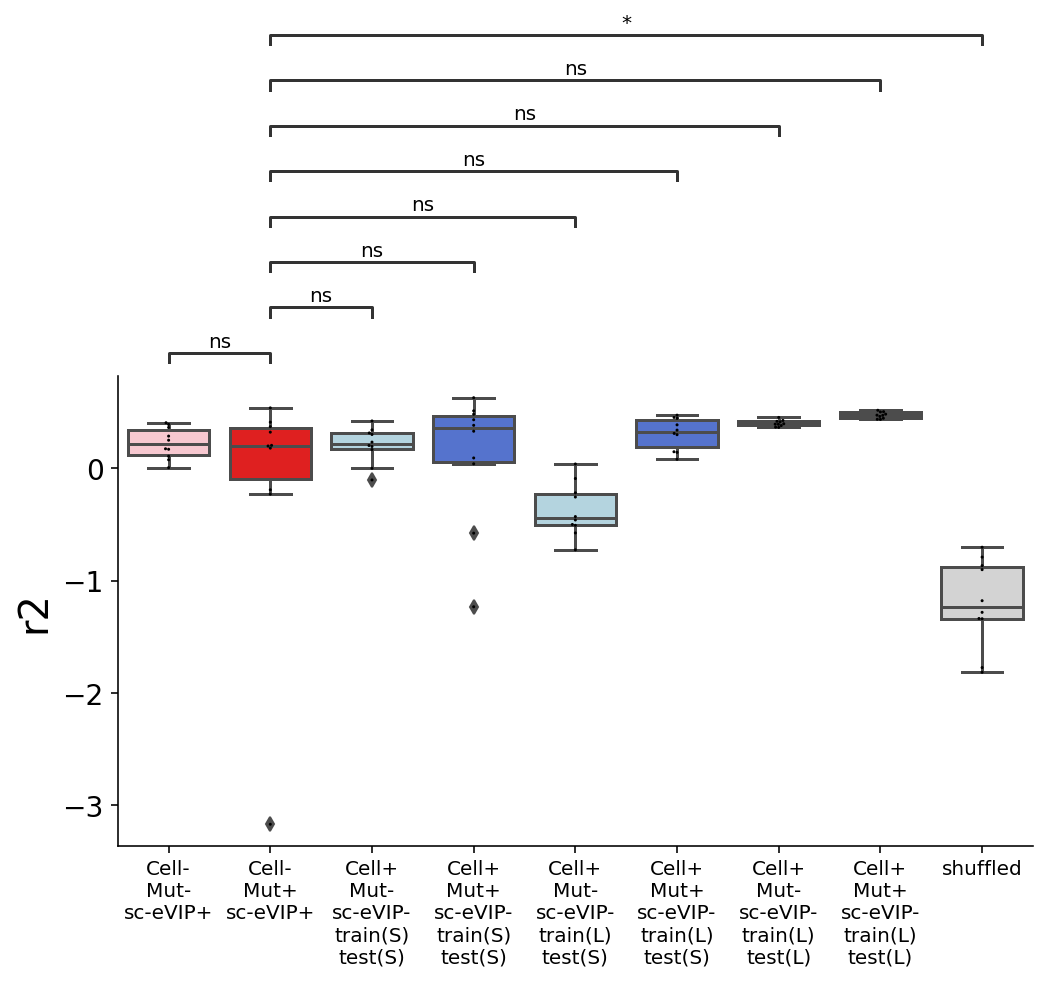

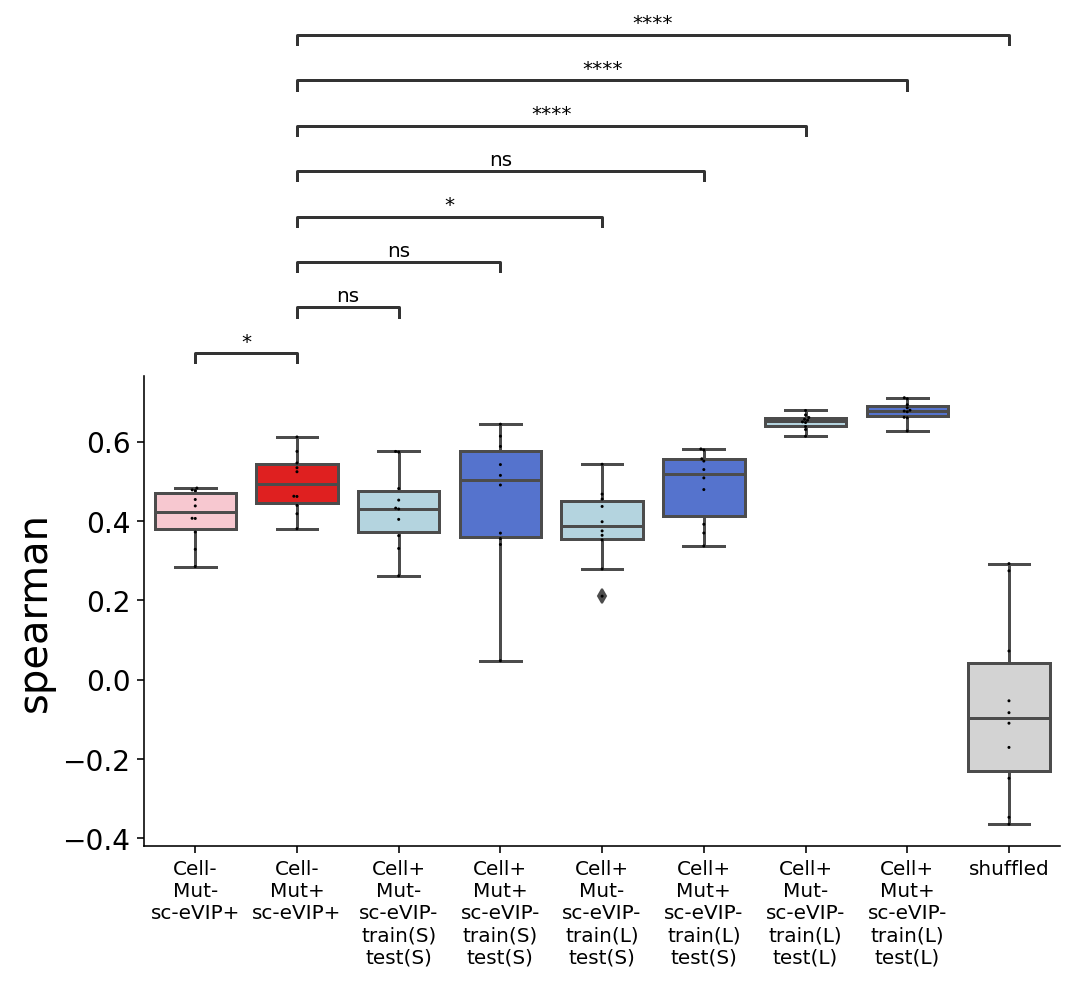

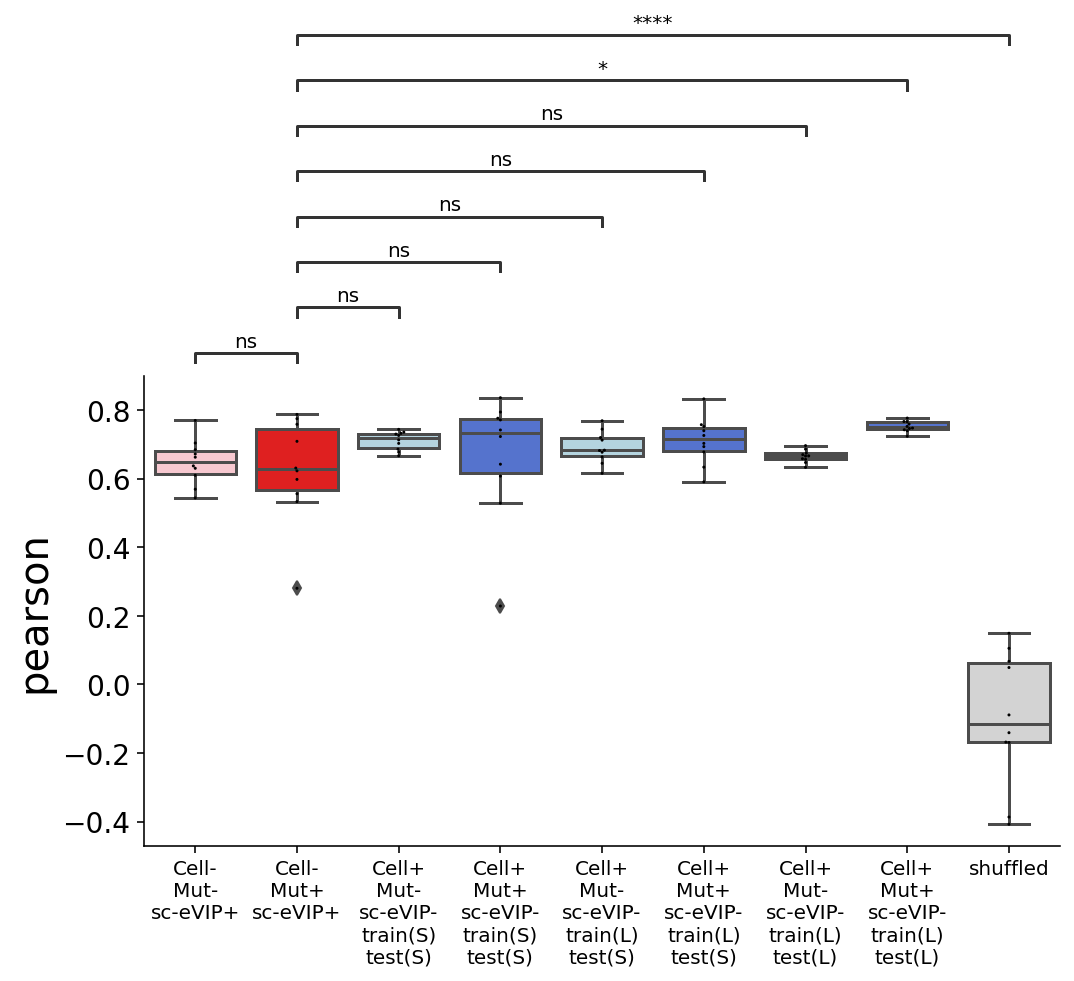

In [17]:
myorder=[]
for i in models:
    myorder.append(re.sub(' ','\n',i))
myorder.append('shuffled')
print('myorder',myorder)

color_dict={}
for m in myorder:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

pairs=[]
comparison='Cell-\nMut+\nsc-eVIP+'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
print(pairs)


def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    if item=='r2':
        print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=1.5
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    #g.set_xticklabels(rotation=45)
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    '''
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    '''
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_full.'+item+'.png',bbox_inches = "tight")

In [18]:
myorder

['Cell-\nMut-\nsc-eVIP+',
 'Cell-\nMut+\nsc-eVIP+',
 'Cell+\nMut-\nsc-eVIP-\ntrain(S)\ntest(S)',
 'Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)',
 'Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S)',
 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S)',
 'Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(L)',
 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)',
 'shuffled']

[('Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)', 'Cell-\nMut+\nsc-eVIP+'), ('Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)', 'Cell-\nMut+\nsc-eVIP+'), ('shuffled', 'Cell-\nMut+\nsc-eVIP+')]
r2                                           Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(S)  \
Cell-\nMut+\nsc-eVIP+                                                 3.161364e-01   
Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)                              4.263794e-01   
Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)                              4.372306e-03   
shuffled                                                              1.347678e-08   

                                          Cell+\nMut-\nsc-eVIP-\ntrain(L)\ntest(S)  \
Cell-\nMut+\nsc-eVIP+                                                 6.494553e-01   
Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)                              5.365316e-02   
Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)                              1.347678e-08   
shuffled                                

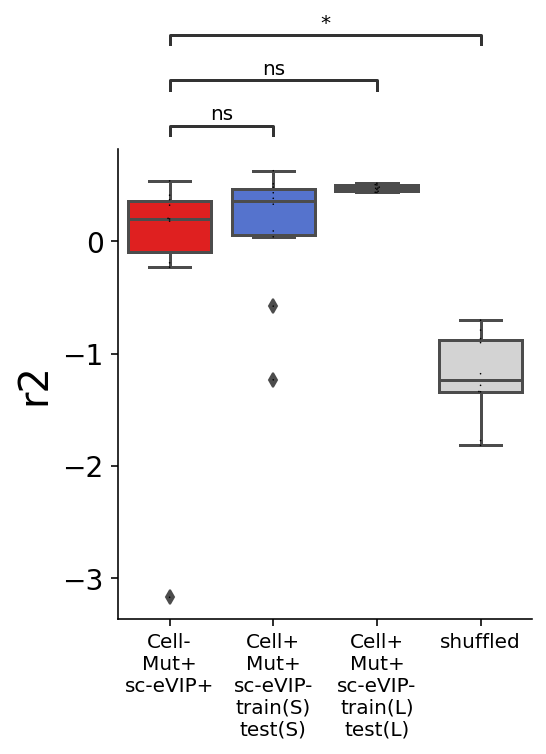

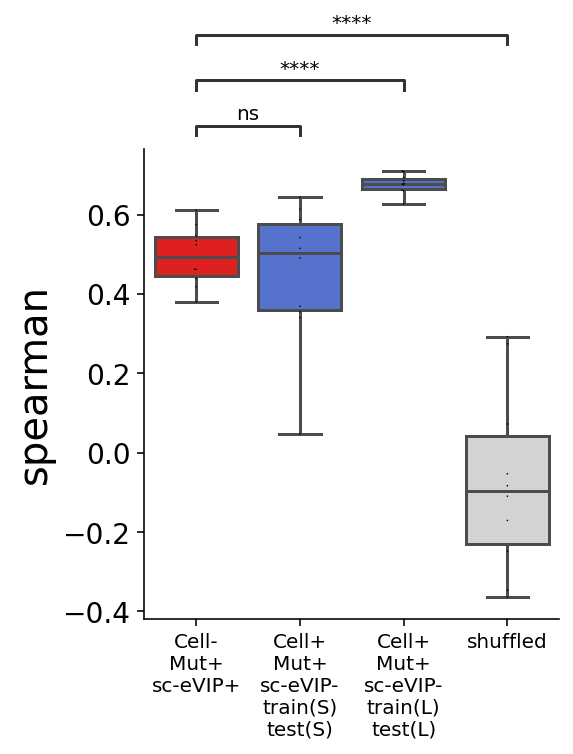

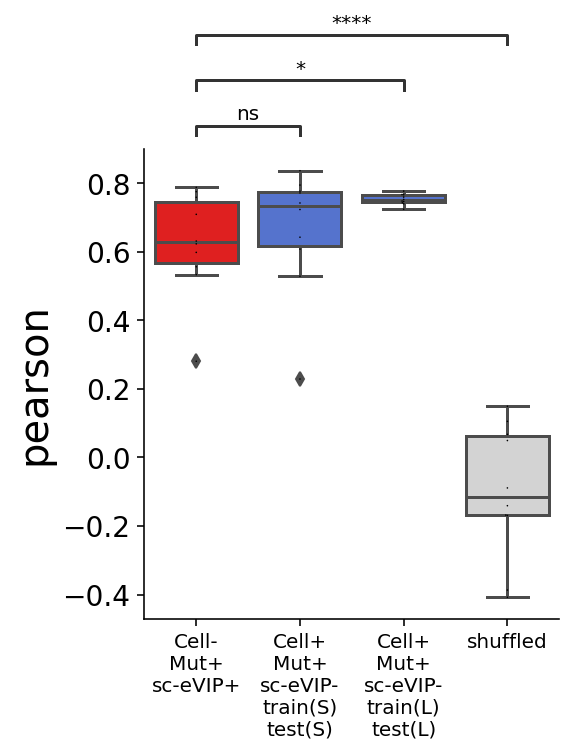

In [22]:
myorder=[
 'Cell-\nMut+\nsc-eVIP+',
 
 'Cell+\nMut+\nsc-eVIP-\ntrain(S)\ntest(S)',

 'Cell+\nMut+\nsc-eVIP-\ntrain(L)\ntest(L)',
 'shuffled']

color_dict={}
for m in myorder:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

pairs=[]
comparison='Cell-\nMut+\nsc-eVIP+'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
print(pairs)


def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    if item=='r2':
        print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=0.8
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    #g.set_xticklabels(rotation=45)
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    '''
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    '''
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)
    
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+PROTEIN+'.LinModels_subset.'+item+'.png',bbox_inches = "tight")

In [ ]:
fold=0
foldname='fold'+str(fold)
preds=pd.read_csv(DATA+'/mutfreq/TP53.training_data.'+foldname+'.pred.csv',
                     sep=' ')
preds.index=list(preds['Allele'])
data['mutational_signature_score']=preds.loc[data.index,'predicted.mutonly.terms']

In [ ]:
#remove the data used for training
data=data.loc[~data['Position'].isin(fold_train_positions),:]
data.shape

In [ ]:
#make the data for all the individual models

for i in range(10):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    data.to_csv(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.csv')
    print(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.csv')

In [ ]:
#read in all the predictions and compute performance

from scipy.stats import spearmanr,pearsonr

performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
ground_truth='IARC_Mutation_Counts'

models=['Cell- Mut- sc-eVIP+',
        'Cell- Mut+ sc-eVIP+',
        
        'Cell+ Mut- sc-eVIP- train(S) test(S)',
        'Cell+ Mut+ sc-eVIP- train(S) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(S)',
        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(L)',
        'Cell+ Mut+ sc-eVIP- train(L) test(L)',
       ]

for i in range(10):
    print('=============== iteration',i)
    foldname='fold'+str(i)
    
    preds=pd.read_csv(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.pred.csv',sep='\t')
    preds.index=preds['Allele']
    
    for modelname in models:
        entries=data.loc[data[foldname],:].index
        if modelname in ['Cell+ Mut+ sc-eVIP- train(S) test(S)',
                        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut+ sc-eVIP- train L test L',
                        
                        'Cell+ Mut- sc-eVIP- train(S) test(S)',
                        'Cell+ Mut- sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut- sc-eVIP- train L test L',
                        
                        'Cell- Mut- sc-eVIP+',
                        'Cell- Mut+ sc-eVIP+']:
            entries=data.loc[data['valid'+foldname],:].index
            
        a=np.log10(1+preds.loc[entries,ground_truth])
        b=np.log10(1+preds.loc[entries,modelname])
        
        #measures
        s=spearmanr(a,b,nan_policy='omit')[0]
        p=pearsonr(a,b)[0]
        from sklearn.metrics import r2_score
        r2=r2_score(a,b)
        
        performances=pd.concat([performances,
                              pd.DataFrame({'condition':re.sub(' ','\n',modelname),
                                           'pearson':p,
                                           'spearman':s,
                                           'r2':r2,
                                           'fold':foldname},index=[modelname+foldname])])
    #also do a shuffled
    entries=data.loc[data['valid'+foldname],:].index
            
    a=np.log10(1+preds.loc[entries,ground_truth])
    b=np.log10(1+preds.loc[entries,ground_truth])
    shuffle_rng=np.random.RandomState(i)
    b=shuffle_rng.choice(b,size=len(b),replace=False)

    #measures
    s=spearmanr(a,b,nan_policy='omit')[0]
    p=pearsonr(a,b)[0]
    from sklearn.metrics import r2_score
    r2=r2_score(a,b)

    performances=pd.concat([performances,
                          pd.DataFrame({'condition':'shuffled',
                                       'pearson':p,
                                       'spearman':s,
                                       'r2':r2,
                                       'fold':foldname},index=['shuffled'+foldname])])

In [ ]:
color_dict={}
for m in models:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

sns.catplot(data=performances,x='condition',y='spearman',kind='box',aspect=2,
           #palette=color_dict
           )


In [ ]:
item='r2'
performances.groupby('condition', as_index=False)[item].mean()

In [ ]:
myorder=[]
for i in models:
    myorder.append(re.sub(' ','\n',i))
myorder.append('shuffled')
print('myorder',myorder)

color_dict={}
for m in myorder:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

pairs=[]
comparison='Cell-\nMut+\nsc-eVIP+'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
print(pairs)


def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    if item=='r2':
        print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=1.5
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    #g.set_xticklabels(rotation=45)
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    '''
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    '''
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)

In [ ]:
#plot for fig 5
fold=0
foldname='fold'+str(fold)
preds=pd.read_csv(DATA+'/mutfreq/TP53.training_data.'+foldname+'.pred.csv',
                     sep=' ')
preds.index=list(preds['Allele'])

anno.loc['unassigned','cluster_color']='slateblue'
fig,plots=plt.subplots()
fig.set_size_inches(5,5)
plots.scatter(anno.loc[sorted_variants,'HotellingT2'],
           mutsig.loc[sorted_variants,'IARC_Mutation_Counts']+1,
           s=preds.loc[sorted_variants,'predicted.mutonly.response']+1,
              c=anno.loc[sorted_variants,'cluster_color'],
              vmax=20,cmap='viridis')
plots.set_xlabel('sc-eVIP score')
plots.set_ylabel('Occurence in patient cohorts')
plots.grid(False)
for i, txt in enumerate(sorted_variants):
        plots.annotate(txt, (anno.loc[sorted_variants,'HotellingT2'][i], 
                             mutsig.loc[sorted_variants,'IARC_Mutation_Counts'][i]+1),
                       fontsize=5,color='lightgray')
plots.set_yscale('log')
#plots.set_xscale('log')
#plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.pdf',bbox_inches = "tight") 
#plt.savefig(FIGS+'/'+PROTEIN+'.EffectSize_vs_mutfreq.png',bbox_inches = "tight")


In [ ]:
data['Signature_1'].min()

In [ ]:
predictions=pd.DataFrame(index=data.index,
                        columns=range(10))

In [ ]:
for fold in range(10):
    foldname='fold'+str(fold)
    preds=pd.read_csv(DATA+'/mutfreq/TP53.training_data.'+foldname+'.pred.csv',
                     sep=' ')
    preds.index=list(preds['Allele'])
    predictions[fold]=preds.loc[predictions.index,'predicted_mutonly']
    

In [ ]:
predictions.head()

In [ ]:
predictions.min()

In [ ]:
#average the predictions
avg_predictions=predictions.mean(axis=1)

In [ ]:
data['mutational_signature_score']=avg_predictions

In [ ]:
#make the data for all the individual models

for i in range(10):
    print('=============== iteration',i)
    #define train, validation sets
    #==============================
    #randomize train/test - by position
    foldname='fold'+str(i)
    rng=np.random.RandomState(i)
    data[foldname]=get_positions_train_valid(copy.deepcopy(data['Position']),rng)
    
    data[foldname+'not']=(data[foldname]==False)
    
    data['train'+foldname]=np.multiply(data['has_effsize'],data[foldname])
    data['valid'+foldname]=np.multiply(data['has_effsize'],data[foldname+'not'])
    data.to_csv(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.csv')
    print(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.csv')

In [ ]:
#read in all the predictions and compute performance

from scipy.stats import spearmanr,pearsonr

performances=pd.DataFrame(columns=['condition','pearson','spearman','r2','fold'])
ground_truth='IARC_Mutation_Counts'

models=['Cell- Mut- sc-eVIP+',
        'Cell- Mut+ sc-eVIP+',
        
        'Cell+ Mut- sc-eVIP- train(S) test(S)',
        'Cell+ Mut+ sc-eVIP- train(S) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(S)',
        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
        
        'Cell+ Mut- sc-eVIP- train(L) test(L)',
        'Cell+ Mut+ sc-eVIP- train(L) test(L)',
       ]

for i in range(10):
    print('=============== iteration',i)
    foldname='fold'+str(i)
    
    preds=pd.read_csv(DATA+'/mutfreq/TP53.model_comparison.'+foldname+'.pred.csv',sep='\t')
    preds.index=preds['Allele']
    
    for modelname in models:
        entries=data.loc[data[foldname],:].index
        if modelname in ['Cell+ Mut+ sc-eVIP- train(S) test(S)',
                        'Cell+ Mut+ sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut+ sc-eVIP- train L test L',
                        
                        'Cell+ Mut- sc-eVIP- train(S) test(S)',
                        'Cell+ Mut- sc-eVIP- train(L) test(S)',
                        #'Cell+ Mut- sc-eVIP- train L test L',
                        
                        'Cell- Mut- sc-eVIP+',
                        'Cell- Mut+ sc-eVIP+']:
            entries=data.loc[data['valid'+foldname],:].index
            
        a=np.log10(1+preds.loc[entries,ground_truth])
        b=np.log10(1+preds.loc[entries,modelname])
        
        #measures
        s=spearmanr(a,b,nan_policy='omit')[0]
        p=pearsonr(a,b)[0]
        from sklearn.metrics import r2_score
        r2=r2_score(a,b)
        
        performances=pd.concat([performances,
                              pd.DataFrame({'condition':re.sub(' ','\n',modelname),
                                           'pearson':p,
                                           'spearman':s,
                                           'r2':r2,
                                           'fold':foldname},index=[modelname+foldname])])
    #also do a shuffled
    entries=data.loc[data['valid'+foldname],:].index
            
    a=np.log10(1+preds.loc[entries,ground_truth])
    b=np.log10(1+preds.loc[entries,ground_truth])
    shuffle_rng=np.random.RandomState(i)
    b=shuffle_rng.choice(b,size=len(b),replace=False)

    #measures
    s=spearmanr(a,b,nan_policy='omit')[0]
    p=pearsonr(a,b)[0]
    from sklearn.metrics import r2_score
    r2=r2_score(a,b)

    performances=pd.concat([performances,
                          pd.DataFrame({'condition':'shuffled',
                                       'pearson':p,
                                       'spearman':s,
                                       'r2':r2,
                                       'fold':foldname},index=['shuffled'+foldname])])

In [ ]:
color_dict={}
for m in models:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

sns.catplot(data=performances,x='condition',y='spearman',kind='box',aspect=2,
           #palette=color_dict
           )


In [ ]:
models

In [ ]:
myorder=[]
for i in models:
    myorder.append(re.sub(' ','\n',i))
myorder.append('shuffled')
print('myorder',myorder)

color_dict={}
for m in myorder:
    if 'Mut+' in m:
        if 'sc-eVIP-' in m:
            co='royalblue'
        if 'sc-eVIP+' in m:
            co='red'
    elif 'Mut-' in m:
        if 'sc-eVIP-' in m:
            co='lightblue'
        if 'sc-eVIP+' in m:
            co='pink'
    else:
        co='lightgray'
    color_dict[m]=co
    
color_dict['shuffled']='lightgray'

pairs=[]
comparison='Cell-\nMut+\nsc-eVIP+'
for x in myorder:
    if x==comparison:
        continue
    pairs.append((x,comparison))
print(pairs)


def pairwise_ttests(df,condition,value):

    pval_m=pd.DataFrame(0.0,index=conditions,columns=conditions)

    for m1 in conditions:
        m1_values=df.loc[df[condition]==m1,value]
        for m2 in conditions:
            m2_values=df.loc[df[condition]==m2,value]

            from scipy.stats import ttest_ind
            res=ttest_ind(m1_values,m2_values,nan_policy='omit')

            pval_m.loc[m1,m2]=res[1]
            pval_m.loc[m2,m1]=pval_m.loc[m1,m2]
            
    #correct for multiple testing
    from statsmodels.stats.multitest import multipletests
    pvals=np.array(pval_m).flatten()
    new_pvals=multipletests(pvals,method='fdr_bh')[1]
    pval_m2=pd.DataFrame(new_pvals.reshape(pval_m.shape),index=pval_m.index,columns=pval_m.columns)
    return(pval_m2)

    
    
from statannot import add_stat_annotation
for item in ['r2','spearman','pearson']:
    
    df=pd.DataFrame({'condition':performances['condition'],
                'value':performances[item]})

    condition='condition'
    value='value'
    conditions=set(df[condition])
    pval_m=pairwise_ttests(df,'condition','value')
    ##print(item,pval_m.loc[myorder,:])
    pvals_anno=[]
    for pair_idx in range(len(pairs)):
        #pvals_anno.append('{:0.2e}'.format(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]]))
        pvals_anno.append(pval_m.loc[pairs[pair_idx][0],pairs[pair_idx][1]])
        
    
    aspect_num=1.5
    g = sns.catplot(x="condition", y=item,kind='box',data=performances,palette=color_dict,
                   order=myorder,aspect=aspect_num)##aspect=1.3)#4)
                    #order=myorder)#,palette=color_dict)
    sns.swarmplot(x="condition", y=item, color="k", size=aspect_num, data=performances, ax=g.ax,order=myorder)
                  #order=myorder);
    #g.set_xticklabels(rotation=45)
        
    ax1 = g.axes[0,0]
    ax1.grid(False)
    
    
    if item=='r2':
        g.ax.set_ylim(-2,1)
        g.ax.set_yticks([-1,0,1])
        g.ax.set_yticklabels([-1,0,1],fontsize=20)
        
    else:
        g.ax.set_ylim(-0.5,1)
        g.ax.set_yticks([-0.5,0,0.5,1])
        g.ax.set_yticklabels([-0.5,0,0.5,1],fontsize=20)
    #g.ax.set_xticks([])
    g.ax.set_xlabel('')
    g.ax.set_ylabel(item,fontsize=20)
    g.ax.set_xticklabels(myorder,fontsize=10)
    
    test_results = add_stat_annotation(ax1,
                                       x="condition", y=item,data=performances,order=myorder,
                                   box_pairs=pairs,
                                       pvalues=pvals_anno,
                                       perform_stat_test=False,
                                       #text_annot_custom=pvals_anno,
                                   text_format='star',
                                   loc='outside', verbose=2)